#  Prosper Loan Analysis
## by Abdalla Hassan Ammar

## Investigation Overview

I explored the Prosper loan dataset to find out what factors contribute to lower interest rate on a loan

we will going to study the Borrowers' interest rates and their effect with other aspects. 
## Dataset Overview
The Prosper loan dataset consists of about 113,000 records (loans) with 81 rows each row contains information about a specific loan that was funded through the Prosper marketplace.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_bef = pd.read_csv('prosperLoanData.csv')

In [3]:
df_bef.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [4]:
df_aft = df_bef[['ListingKey', 'CreditGrade','ClosedDate','BorrowerAPR','BorrowerRate', 'EstimatedEffectiveYield'
          ,'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)','BorrowerState','EmploymentStatus'
          , 'EmploymentStatusDuration','IsBorrowerHomeowner', 'DebtToIncomeRatio','IncomeRange', 'StatedMonthlyIncome'
          , 'LoanOriginalAmount', 'LoanOriginationDate','PercentFunded', 'Investors']]

In [5]:
df_aft.columns = map(str.lower, df_aft.columns)

In [6]:
df_aft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   listingkey                 113937 non-null  object 
 1   creditgrade                28953 non-null   object 
 2   closeddate                 55089 non-null   object 
 3   borrowerapr                113912 non-null  float64
 4   borrowerrate               113937 non-null  float64
 5   estimatedeffectiveyield    84853 non-null   float64
 6   prosperrating (alpha)      84853 non-null   object 
 7   prosperscore               84853 non-null   float64
 8   listingcategory (numeric)  113937 non-null  int64  
 9   borrowerstate              108422 non-null  object 
 10  employmentstatus           111682 non-null  object 
 11  employmentstatusduration   106312 non-null  float64
 12  isborrowerhomeowner        113937 non-null  bool   
 13  debttoincomeratio          10

In [7]:
# Merge the prosperrating (alpha) into the creitgrade
df_aft.creditgrade.fillna(df_aft['prosperrating (alpha)'], inplace=True)
# Handle remaining null as OFF
df_aft['creditgrade'] = df_aft.creditgrade.fillna('NC')
#Drop the prosperrating (alpha) column, we do not need it.
df_aft = df_aft.drop(['prosperrating (alpha)'], axis = 1)
# Define rhe numbers as a string
df_aft['listingcategory (numeric)'] = df_aft['listingcategory (numeric)'].astype(str)
# use .replace and replace each variable
df_aft['listingcategory (numeric)'] = df_aft['listingcategory (numeric)'].replace({'0' : 'Not Available', '1' : 'Debt Consolidation', '2' : 'Home Improvement'
                                                                             , '3' : 'Business', '4' : 'Personal Loan', '5' : 'Student Use'
                                                                             , '6' : 'Auto', '7' : 'Other', '8' : 'Baby&Adoption'
                                                                             , '9' : 'Boat', '10' : 'Cosmetic Procedure', '11' : 'Engagement Ring'
                                                                             , '12' : 'Green Loans', '13' : 'Household Expenses', '14' : 'Large Purchases'
                                                                             , '15' : 'Medical/Dental', '16' : 'Motorcycle', '17' : 'RV'
                                                                             , '18' : 'Taxes', '19' : 'Vacation', '20' : 'Wedding Loans'})
# Rename the lisitng category column no spaces and parenthesis
df_aft.rename(columns = {"listingcategory (numeric)" : "listingcat"}, inplace = True)
df_aft.loanoriginationdate = pd.to_datetime(df_aft.loanoriginationdate)
# Fill borrowerapr nulls with the means
df_aft['borrowerapr'] = df_aft.borrowerapr.fillna(df_aft['borrowerapr'].mean())
# Make employmentstsatusduration years not months
df_aft['employmentstatusduration'] = df_aft['employmentstatusduration']/12
# astype categorial
df_aft.creditgrade = df_aft.creditgrade.astype('category')
df_aft.incomerange = df_aft.incomerange.astype('category')
df_aft.listingcat = df_aft.listingcat.astype('category')

In [8]:
ovd = {'CreditGrade': ['NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'ProsperRating (Alpha)': ['N/A', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA']}

for var in ovd:
    o_v = pd.api.types.CategoricalDtype(ordered=True, categories=ovd[var])
    df_bef[var] = df_bef[var].astype(o_v)


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## How is Borrower Rate distributed?

* BorrowerRate is normally distributed with a slight left skew
* There's a large spike around the 30% value

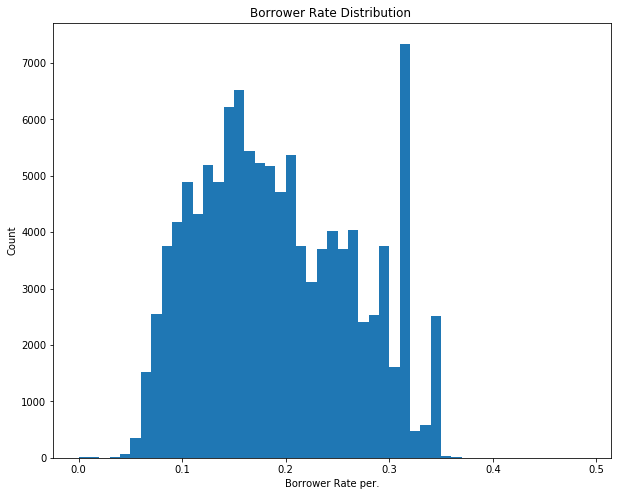

In [9]:
# Plot the distribution of BorrowerRate
rate_bins = np.arange(df_aft.borrowerrate.min(), df_aft.borrowerrate.max(), 0.01)

plt.figure(figsize = [10, 8])

plt.hist(data=df_aft, x='borrowerrate', bins=rate_bins)
plt.xlabel('Borrower Rate per.');
plt.ylabel('Count')
plt.title('Borrower Rate Distribution ');

## What factors contribute to a loan's interest rate?



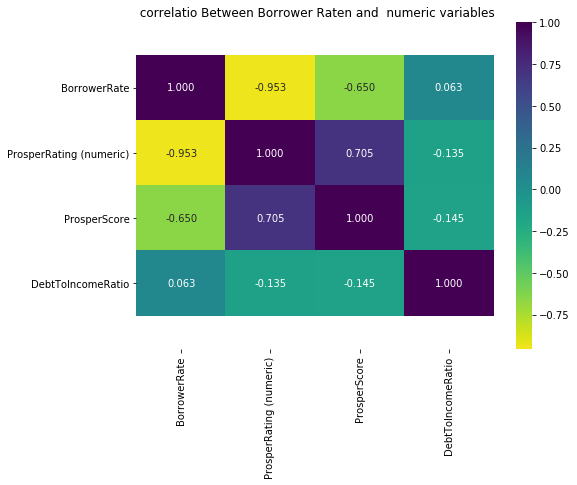

In [10]:
cor = df_bef[['BorrowerRate', 'ProsperRating (numeric)', 'ProsperScore', 'DebtToIncomeRatio']]

# correlation plot of numeic variables
plt.figure(figsize = [8, 6])
sb.heatmap(cor.corr(), annot = True, fmt = '.3f',cmap = 'viridis_r', center = 0)
plt.title(' correlatio Between Borrower Raten and  numeric variables')

# I got that from github
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# # fix for mpl bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# fix for mpl bug that cuts off top/bottom of seaborn viz

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0);
plt.show()


## Who pays the lowest interest rate?



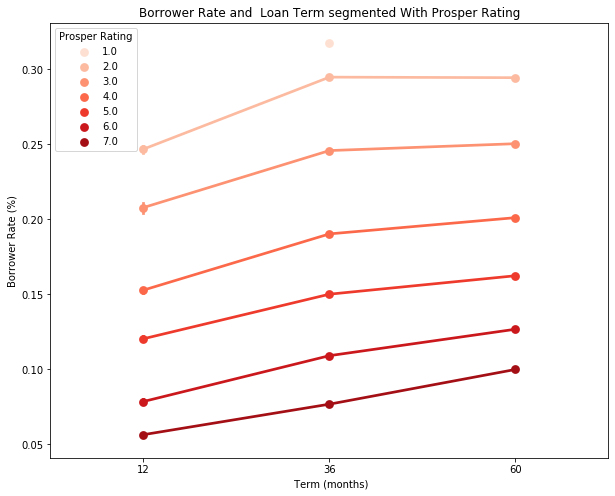

In [11]:
fig = plt.figure(figsize=[10,8])

ax = sb.pointplot(data=df_bef, x='Term', y='BorrowerRate', hue='ProsperRating (numeric)',
                   palette='Reds');
plt.legend(loc=2, title='Prosper Rating');
plt.ylabel('Borrower Rate (%)')
plt.xlabel(' Term (months)')
plt.title('Borrower Rate and  Loan Term segmented With Prosper Rating');

lets look to APR an isolation to understand what might be considered normal

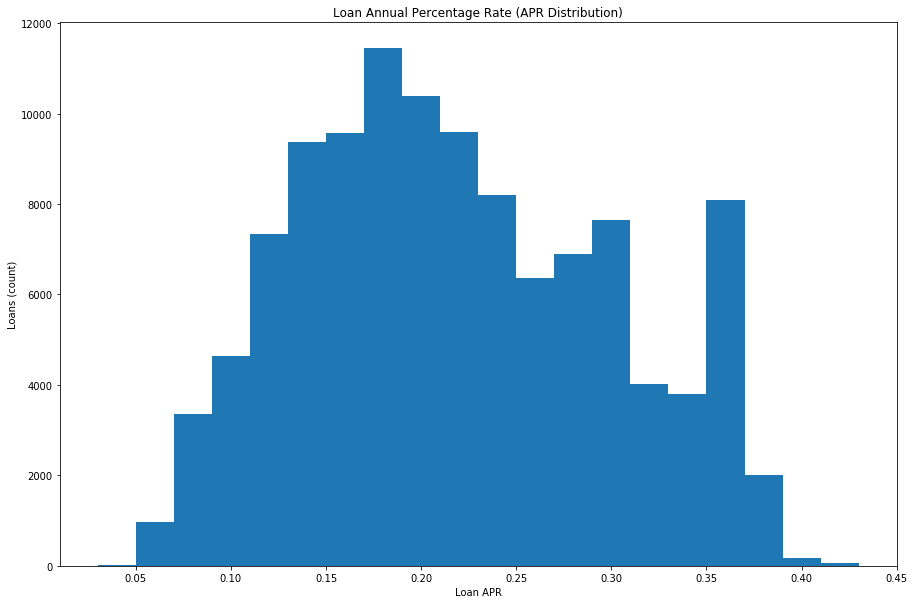

In [12]:
# #Dictionary to alter font
# t_f = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}
# l_f ={'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 14}

# Using Hist to plot our distribution for APR

bins = np.arange(0.03, 0.45, 0.02)
plt.figure(figsize=(15,10))
plt.hist(data = df_bef, x = 'BorrowerAPR', bins=bins)
plt.title('Loan Annual Percentage Rate (APR Distribution)')
plt.xlabel('Loan APR')
plt.ylabel('Loans (count)');

### Prosper Score Impact on APR Over Time

In [13]:
# Add year column
df_bef['Year'] = pd.to_datetime(df_bef['ListingCreationDate']).dt.year
# Check this was completed correctly
df_bef.Year.head()

0    2007
1    2014
2    2007
3    2012
4    2013
Name: Year, dtype: int64

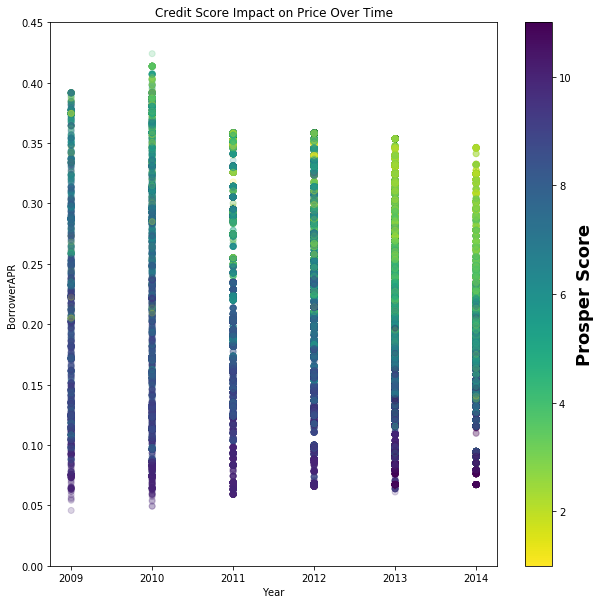

In [14]:

plt.gcf().set_size_inches(10, 10)
plt.subplots_adjust(wspace=0.3)
plt.scatter(data=df_bef, x='Year', y='BorrowerAPR', c='ProsperScore', cmap='viridis_r', alpha=0.2);
cbar = plt.colorbar()
cbar.solids.set(alpha=1)
plt.title('Credit Score Impact on Price Over Time');
plt.xlabel('Year')
plt.ylabel('BorrowerAPR');
plt.yticks(np.arange(0, 0.5, step=0.05));
cbar.set_label(label='Prosper Score',size=18,weight='bold');


 Appetite for risk has increased over time

Best rates (below 10%) are reserved for the best Prosper Scores (10+)

 2011 onwards max APR has dropped from above 40% to slightly above 36% 
 
 
 2013 - 2014 Prosper Score follows a gradual transition from purple to yellow, investors seemed to have really adopted this risk rating




> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!